# B-Spline

In [1]:
# Based on the notes
# INTEREST RATES AND FX MODELS: 1. LIBOR and OIS
# by Andrew Lesniewski

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import normal, seed
#%matplotlib notebook

from bspline import BSpline

A B-spline of degree $d\geq 0$ is a function $f(t)$ of the form
$$
    f(t) = \sum_{-\infty \leq k \leq \infty} f_k B_k ^{(d)}(t)
$$

Where we define, for a sequence of knot points $\{t_k\}_{- \infty \leq k \leq \infty}$

$$B_k^{(0)}(t) =
    \begin{cases}
    1 & t_k \leq t < t_{k+1} \\
    0 & \text{otherwise}
    \end{cases}
$$

And, recursively, for $d\geq 1$,
$$
   B_k^{(d)}(t) = \frac{t - t_k}{t_{k+d} - t_k} B_k^{(d-1)}(t) + \frac{t_{k+d+1} - t}{t_{k+d+1} - t_{k+1}} B_{k+1}^{(d-1)}(t)
$$

In [2]:
knots = np.array([-3, -2, 0, 1, 3, 6])
bspline = BSpline(knots, 3)

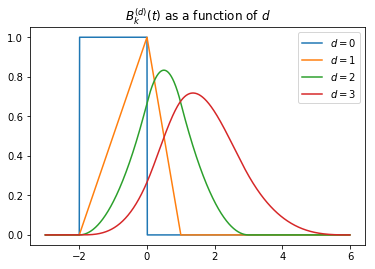

In [3]:
T = np.arange(-3, 6, 0.01)

for d in range(4):
    plt.plot(T, bspline.keval(T, 1, d), label="$d={}$".format(d))
    
plt.legend()
plt.title(r"$B_k^{(d)}(t)$ as a function of $d$")
plt.show()

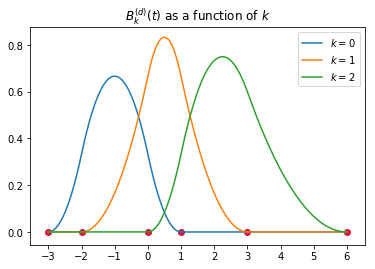

In [4]:
degree = 2
bs1 = BSpline(knots, degree)

for k in range(3):
    plt.plot(T, bs1.keval(T, k), label="$k={}$".format(k))
plt.scatter(bs1.knots, np.zeros(len(bs1.knots)), c="crimson")
plt.legend()
plt.xticks(range(-3,7))
plt.title(r"$B_k^{(d)}(t)$ as a function of $k$")
plt.show()

#### B-Spline Derivative
For the derivative we have the following recursion
$$
    \frac{d}{dt}B_{d}^{k}(t) = \frac{d}{t_{k+d} - t_k}B_{d-1}^{k}(t) - \frac{d}{t_{k+d+1} - t_{k+1}}B_{d-1}^{k+1}(t)
$$



In [5]:
bspline.diff(1, 1)

0.23333333333333331

#### B-Spline Integration
The integral from $-\infty$ to $t$ can be expressed in terms of a sum as follows:
$$
    \int_{-\infty}^{t} B_k^{(d)}(s) ds = \sum_{i=k}^{\infty}\frac{t_{k+d+1}- t_k}{d + 1}B_i^{(d+1)}(t)
$$

Where we require at least $d + 2$ knot points greater than or equal to $t$

In [6]:
knots = np.array([-3, -2, 0, 1, 3, 6])
bspline.integrate(0, 1)

0.90208333333333346

### Playing with B-Splines
If we have $6$ knots, modifying $f_k$ for all $k=0,\ldots, 5$ creates an instance of
$$
f(t) = \sum_{k} f_k B_k ^{(d)}(t)
$$

In [7]:
from ipywidgets import interact, FloatSlider
from numpy import vectorize

knots = np.array([-3, -2, 0, 1, 3, 6, 7, 8])
bspline = BSpline(knots, 3)

@vectorize
def BSpline_Eval(x, *args):
    coefs = args
    return np.sum([coefs[ix] * bspline.keval(x, k, out_bounds_eval=True)
                   for ix, k in enumerate(bspline.knots)])

def plot_bspline(**kwargs):
    args = list(kwargs.values())
    X = np.linspace(-3, 5)
    Y = BSpline_Eval(X, *args)
    plt.plot(X, Y)
    plt.show()

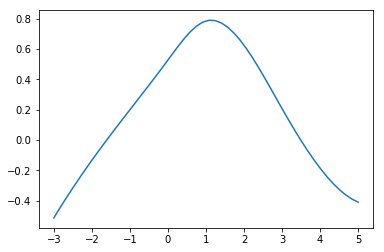

In [8]:
interact(plot_bspline,
         a0 = FloatSlider(value=1, min=-1, max=2, step=0.1),
         a1 = FloatSlider(value=1, min=-1, max=2, step=0.1),
         a2 = FloatSlider(value=1, min=-1, max=2, step=0.1),
         a3 = FloatSlider(value=1, min=-1, max=2, step=0.1),
         a4 = FloatSlider(value=1, min=-1, max=2, step=0.1),
         a5 = FloatSlider(value=1, min=-1, max=2, step=0.1),
         a6 = FloatSlider(value=1, min=-1, max=2, step=0.1),
         a7 = FloatSlider(value=1, min=-1, max=2, step=0.1))

# Curve construction by B-splines ﬁtting

To value a mid-market swap:
$$
    P_0^{fix} = P_0^{float}.
$$

Implies
$$
    \sum_{j=1}^{n_c}C\cdot \iota_j\cdot P_0(t, T_j^c) = \sum_{j=1}^{n_f}L_0(T_{j-1}^f, T_j^f)\cdot \upsilon_j\cdot P_0(t, T_j^c)
$$

Where:
1. $\iota_i$ and $\upsilon_i$ denote the day count fractions for the fixed and floating legs respectively;
2. $P_0(S,T)$ denotes the discount factor

Consider $C$ to be the coupon of a **mid-market swap**. In that case,
$$
    C = \frac{\sum_{j=1}^{n_f}L_0(T_{j-1}^f, T_j^f)\cdot \upsilon_j\cdot P_0(t, T_j^c)}
             {\sum_{j=1}^{n_c}\cdot \iota_j\cdot P_0(t, T_j^c)}
$$

Then, we would like to find $C$ such that
$$
    C - \frac{\sum_{j=1}^{n_f}L_0(T_{j-1}^f, T_j^f)\cdot \upsilon_j\cdot P_0(t, T_j^c)}
             {\sum_{i=1}^{n_c}\cdot \iota_i\cdot P_0(t, T_i^c)}  = 0
$$

Where we define

$$
    P_0(S, T) = \exp\left(-\sum_{k=-3}^N \gamma_k(S,T) \cdot f_k\right)
$$

$$
    L_0(S, T) = \frac{1}{\tau}\left(\exp\left(\sum_{k=-3}^{N}\gamma_k(S,T) \cdot l_k\right)-1\right)
$$

and $\gamma_k(S,T) := \int_S^TB_k(s) ds$, and $\ell_0 = \left(\sum_{k=-3}^{N}\gamma_k(S,T) \cdot l_k\right)$

$$
L_0(S, T) = \frac{1}{\tau}\left(-\ell_0-1\right)
$$

In [98]:
nx1_instruments = np.array([1, 3, 6, 9, 13, 26, 39, 52, 65, 91, 130, 156, 195, 260, 390])
mid_mkt = np.array([0.0409 ,  0.04315,  0.0446 ,  0.046  ,  0.04765,  0.05035,
                    0.05245,  0.0543 ,   0.05605,  0.05905,  0.06215,  0.06401,
                    0.0668 ,  0.06911,  0.07142])

coefs = np.ones(len(nx1_instruments))
bspline = BSpline(nx1_instruments, 3)

In [99]:
nflows = np.array([28, 84, 169, 252, 364, 728, 1092, 1456, 1820, 2548, 3640, 4368, 5460, 7280, 10920])

In [106]:
d_factors_init = np.random.randn(bspline.len_knots)
f_factors_init = np.random.randn(bspline.len_knots)

discount_factors = np.exp(-bspline.integrate_coef(d_factors_init, nx1_instruments).cumsum() / 100)
forward_factors = np.exp(-bspline.integrate_coef(f_factors_init, nx1_instruments).cumsum() / 100)

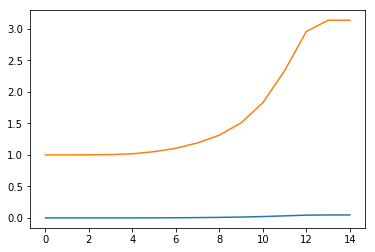

In [150]:
ell0 = bspline.integrate_coef(f_factors_init, nx1_instruments).cumsum() / 100
forward_factors = 1/28 * (np.exp(ell0) - 1)
discount_factors = np.exp(-bspline.integrate_coef(d_factors_init, nx1_instruments).cumsum() / 100)

plt.plot(forward_factors)
plt.plot(discount_factors)
plt.show()

In [124]:
np.insert(nx1_instruments, 0, 0)

array([  0,   1,   3,   6,   9,  13,  26,  39,  52,  65,  91, 130, 156,
       195, 260, 390])

In [130]:
ell0 = []
n_instruments = np.insert(nx1_instruments, 0, 0)
for ix, v in enumerate(n_instruments[:-1]):
    inf, sup = n_instruments[(ix, ix+1),]
    ell0.append(bspline.integrate_coef(d_factors_init, sup, inf))
ell0 = np.array([ell0])

In [205]:
def value_swaps(coefs, target_values, bspline_model):
    d_factors = np.array(coefs[:bspline_model.len_knots])
    f_factors = np.array(coefs[bspline_model.len_knots:])
    
    discount_factors = np.exp(-bspline.integrate_coef(d_factors,
                                                      bspline_model.knots).cumsum() / 100)
    
    # TODO: Add function to forward factors; vectorize function (slow as shhhht)
    # TODO: Fix number of days convention
    ell0 = []
    n_instruments = np.insert(bspline_model.knots, 0, 0)
    for ix, v in enumerate(n_instruments[:-1]):
        inf, sup = n_instruments[(ix, ix+1),]
        ell0.append(bspline_model.integrate_coef(d_factors, sup, inf))
    ell0 = np.array([ell0])
    
    forward_factors = np.exp(ell0 / 100).cumsum() - 1
    
    par_swaps = np.cumsum(1 /28 * forward_factors * discount_factors) / np.cumsum(discount_factors)
    err2 = np.sum(target_values - par_swaps) ** 2
    print(err2)
    return err2

In [206]:
from scipy.optimize import minimize, fmin_powell

In [207]:
x0 = normal(size=2 * len(bspline.knots))

In [208]:
minimize(value_swaps, x0, args=(mid_mkt, bspline))

1.05951788139
1.05951787016
1.05951787057
1.05951787118
1.05951787182
1.05951787286
1.05951787445
1.05951787612
1.05951787737
1.05951787849
1.05951788009
1.05951788139
1.05951788139
1.05951788139
1.05951788139
1.05951788139
1.05951788139
1.05951788139
1.05951788139
1.05951788139
1.05951788139
1.05951788139
1.05951788139
1.05951788139
1.05951788139
1.05951788139
1.05951788139
1.05951788139
1.05951788139
1.05951788139
1.05951788139
1.05951788139
0.334881495165
0.334881495165
0.334881492843
0.334881493056
0.334881493358
0.334881493637
0.334881494026
0.334881494495
0.334881494837
0.334881494995
0.334881495075
0.334881495137
0.334881495165
0.334881495165
0.334881495165
0.334881495165
0.334881495165
0.334881495165
0.334881495165
0.334881495165
0.334881495165
0.334881495165
0.334881495165
0.334881495165
0.334881495165
0.334881495165
0.334881495165
0.334881495165
0.334881495165
0.334881495165
0.334881495165
0.334881495165
0.281018652771
0.281018652771
0.281018650907
0.281018651099
0.2810186513

      fun: 4.213076788522929e-08
 hess_inv: array([[ 659.59307299,  560.98615386,  429.93304909,  322.14128998,
         186.37687197,   47.5452429 ,  -29.00525822,  -47.56658751,
         -43.52483079,  -22.57617804,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ],
       [ 560.98615386,  478.84431807,  366.21278782,  274.39520447,
         158.75035969,   40.49318923,  -24.71205161,  -40.52167335,
         -37.07778253,  -19.23191505,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.     

In [209]:
coef_minimum = _

In [211]:
coef_minimum["x"]

array([ 5.81668713,  5.45498083,  6.43540559,  4.07120564,  1.37914683,
        1.92613803,  0.84051728, -1.60563281, -0.16381872, -0.38210079,
        1.01888309, -0.27392706, -0.16700179, -2.08592818,  0.80867758,
       -0.1493616 , -1.25730499,  0.08670499, -1.35924628, -2.49541693,
       -1.57533572,  0.67576122, -1.3249717 ,  0.78166757, -0.07419014,
       -0.54987032,  1.02495952, -1.66795844,  1.83463205, -1.24188682])

In [224]:
discountf = coef_minimum["x"][bspline.len_knots:]
forwardf = coef_minimum["x"][:bspline.len_knots]

In [231]:
vals = np.exp(-bspline.integrate_coef(discount_factors, bspline.knots).cumsum() / 100)

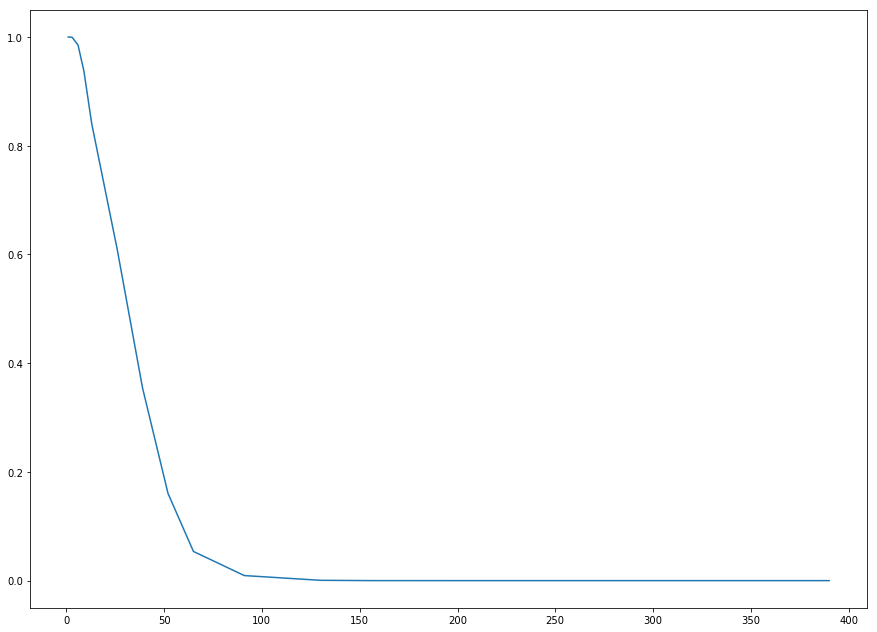

In [234]:
plt.figure(figsize=(15,11))
plt.plot(nx1_instruments, vals)
plt.show()

In [235]:
vals

array([  1.00000000e+00,   9.99500125e-01,   9.85166791e-01,
         9.37462852e-01,   8.40588205e-01,   6.09981169e-01,
         3.54124719e-01,   1.60434839e-01,   5.36677848e-02,
         9.29232851e-03,   5.75440826e-04,   1.58373667e-05,
         4.76364876e-07,   1.98455038e-07,   1.98455038e-07])